<img src="./fiuba.jpg" align="right" width="150" /> 
#### Procesamiento Digital de Se√±ales

# Trabajo Pr√°ctico 1
#### Nombre y Apellido: Rodrigo Alejandro Tirapegui

***
## Procesos aleatorios


<div class="alert alert-block alert-info">
    
### Recepci√≥n de una se√±al degrada

+ ##### Un receptor de comunicaciones posee un frontend anal√≥gico que recibe se√±ales moduladas en PAM (Pulse Amplitude Modulation), por medio de pulsos de forma exponencial.
+ ##### El canal por el cual viajan estos pulsos es un canal AWGN (Additive White Gaussian Noise), por lo cual la se√±al recibida se ver√° degradada notablemente. En principio, se puede suponer que afecta de forma independiente a cada muestra de la se√±al.
+ ##### Se dispone una trama digitalizada muestrada a 20 samples / pulso. La trama contiene un header de 16 bytes donde cada byte es: 10101100. La modulaci√≥n empleada es antipodal:
> ###### pulso positivo -> bit 1
> ###### pulso negativo -> bit 0

### Notas:

+ ##### La se√±al se encuentra sincronizada a nivel muestra. Por esta raz√≥n, la muestra 0 corresponde al comienzo de un pulso exponencial.
+ ##### Tener en cuenta que el objetivo es recuperar la informaci√≥n, lo cual no implica recuperar fielmente la se√±al enviada. Esto es cl√°sico en problemas de comunicaciones: sabemos la forma de la modulaci√≥n (la forma de los pulsos y como se modulan), lo que no sabemos es con qu√© valores fueron modulados.

</div>

<div class="alert alert-block alert-info">
    
### Objetivos principales:

+ ##### Detectar la secuencia de bits recibida de forma confiable. 

+ ##### Investigar diferentes m√©todos de demodulaci√≥n.

</div>

<div class="alert alert-block alert-info">
    
#### PARTE 1

##### a) Filtrar la se√±al con un filtro digital para eliminar potencia de ruido. Pueden probar con filtros FIR o IIR, los que les parezcan convenientes.  ¬øEs √≥ptimo el filtro elegido para detectar la informaci√≥n en forma confiable?

</div>

Se presentan dos se√±ales en los archivos signal.npy y signalLowSNR.npy. Adem√°s, se presenta una tercera se√±al con los pulsos de forma exponencial utilizados en la modulaci√≥n PAM de las primeras dos se√±ales.

A continuaci√≥n se grafica cada una de las se√±ales a analizar:

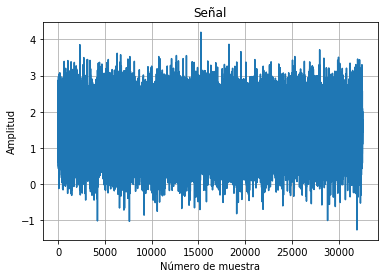

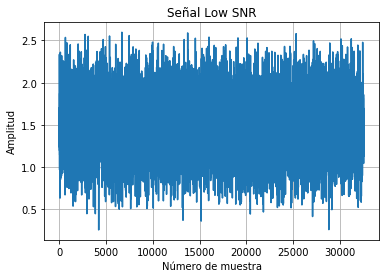

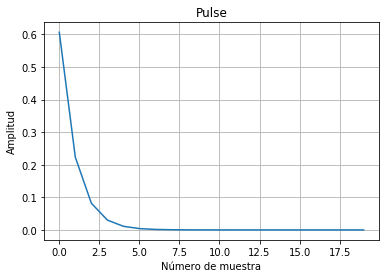

In [3]:
#%% Inicializacion
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.signal as sig
import scipy.fftpack as sc

#%% Generacion de se√±ales

# Obtenci√≥n de datos
signal = np.load('signal.npy')
signalLowSNR = np.load('signalLowSNR.npy')
pulse = np.load('pulse.npy')

# Graficado de se√±ales
figures = ['Se√±al', 'Se√±al Low SNR', 'Pulse']
xlabel = 'N√∫mero de muestra'
ylabel = 'Amplitud'

plt.close('all')

# Se√±al
plt.figure(figures[0])
plt.title(figures[0])
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.grid(which='both', axis='both')
plt.plot(signal)

# Se√±al Low SNR
plt.figure(figures[1])
plt.title(figures[1])
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.grid(which='both', axis='both')
plt.plot(signalLowSNR)

# Pulse
plt.figure(figures[2])
plt.title(figures[2])
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.grid(which='both', axis='both')
plt.plot(pulse)



Con el objetivo de determinar la plantilla del filtro a dise√±ar para eliminar la potencia de ruido, se procede a analizar el espectro del pulso de forma exponencial.


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<StemContainer object of 3 artists>

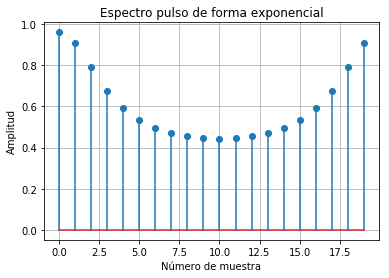

In [4]:
# Calculo del espectro del pulso
S_pulse = np.fft.fft(pulse)

# Graficado del espectro de la se√±al pulso
plt.figure()
plt.title('Espectro pulso de forma exponencial')
plt.xlabel('N√∫mero de muestra')
plt.ylabel('Amplitud')
plt.grid(which='both', axis='both')
plt.stem(S_pulse)

Dado que la trama digitalizada fue muestreada a 20 samples/pulso, y dado que el teorema de Nyquist demuestra que la reconstrucci√≥n exacta de una se√±al peri√≥dica a partir de sus muestras es posible si la tasa de muestreo es superior al doble de su ancho de banda $(2B)$, puede decirse que en la digitalizaci√≥n se utiliz√≥ una relaci√≥n de sobremuestreo de la se√±al $M = 20$, donde $M = f_{os}/f_s$, con $f_{os}$ igual a la frecuencia de sobremuestreo y $f_s = f_{Ny} = 2B$.

Por lo tanto, el grafico precedente muestra el espectro de la se√±al pulso en el rango $[0,f_{os}]$, siendo la muestra $N = 10$ la correspondiente a la frecuencia $f_{os}/2$.

De este modo, como lo que se busca es eliminar la potencia de ruido presente hasta el ancho de banda de la se√±al, se decide utilizar la t√©cnica de $sobremuestreo + decimaci√≥n$.

En t√©rminos generales, la $decimaci√≥n$ es el proceso combinado de filtrado y reducci√≥n de la resoluci√≥n lo cual, en la pr√°ctica, implica el filtrado pasa bajo de una se√±al y luego desechar algunas de sus muestras (proceso conocido como $downsampling$).

Esta t√©cnica es t√≠picamente usada (por ejemplo) por los conversores A/D del tipo sigma-delta, debido a la sencillez del filtro antialias y a la significativa reducci√≥n del ruido de cuantizaci√≥n que permiten lograr.

<img src="./Oversampling filtering.png" align="center" width="50%" />

En este sentido, dado que $f_s = f_{os}/M$, si se normaliza el gr√°fico a $f_{os} = 1$, entonces $f_s = 0.05$, y $B = f_s/2 = 0.025$.

Por lo tanto, se decide utilizar el toolbox PyFDA para dise√±ar un filtro que cumpla con la siguiente plantilla:

> + $f_{PB} = 0.025$
> + $f_{SB} = 0.5$

En relaci√≥n con la distorsi√≥n en la banda de paso, se define como alteraci√≥n m√°xima admisible 0,01 dB, resultando:

> + $A_{PB}[dB] = 0.01$

En relaci√≥n con la atenuaci√≥n m√≠nima en la banda de atenuaci√≥n, se propone que la amplitud de ruido represente como m√°ximo el 0,1% de la amplitud de la se√±al, lo que determina:

> + $A_{SB}[dB] = 60$

Luego, se aplica el filtro obtenido a la se√±al en cuesti√≥n, y se elimina una cada M muestras ($M:1‚Üì$) con los objetivos de reducir la frecuencia de muestreo a un valor cercano a la de Nyquist y de eliminar la potencia de ruido por fuera de la banda base.


Para implementar la parte de filtrado pasa bajo pueden utilizarse los filtros FIR o IIR.

Dado que en el caso de los FIR cualquier salida es una funci√≥n s√≥lo de las entradas anteriores (porque no hay retroalimentaci√≥n), s√≥lo hay que calcular las salidas que se utilizar√°n. En cambio, en los IIR, debe realizarse parte o la totalidad del c√°lculo del filtro para cada entrada, incluso cuando no se usar√° la salida correspondiente.

Por lo tanto, el hecho de que solo se deban calcular las salidas que se utilizaran es una raz√≥n para implementar un filtro FIR en lugar de un IIR.

Adem√°s, como lo que se busca es analizar las muestras temporales luego del proceso de $decimaci√≥n$, resulta conveniente implementar un FIR en lugar de un IIR, dado que al ser los primeros de fase lineal (y por lo tanto, de retardo de grupo constante), distorsionan menos la se√±al de entrada.

> + Se dise√±√≥ un filtro pasabajos FIR de orden N = 8 utilizando la t√©cnica equiripple. 

Se grafican a continuaci√≥n las primeras 128 muestras de las se√±ales digitalizadas filtradas signal.npy y signalLowSNR.npy.


C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


<StemContainer object of 3 artists>

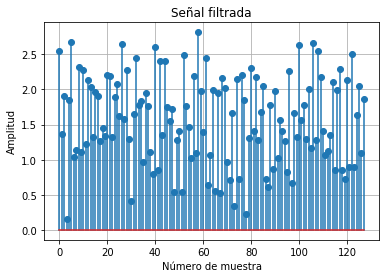

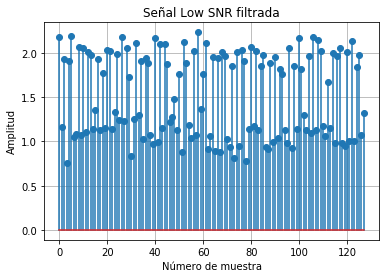

In [5]:
# Obtenci√≥n del filtro FIR antialias y filtado
data = np.load('FIR_FAA.npz')
h_lp = data['ba']
b_lp = h_lp[0]
a_lp = h_lp[1]
signal_lp_filtered = sig.filtfilt(b_lp, a_lp, signal);
signalLowSNR_lp_filtered = sig.filtfilt(b_lp, a_lp, signalLowSNR);

# Decimaci√≥n
signal_filtered = signal_lp_filtered[1::20]
signalLowSNR_filtered = signalLowSNR_lp_filtered[1::20]

# Graficado de las se√±ales filtradas
figures = ['Se√±al filtrada', 'Se√±al Low SNR filtrada']
xlabel = 'N√∫mero de muestra'
ylabel = 'Amplitud'

# Se√±al filtrada
plt.figure(figures[0])
plt.title(figures[0])
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.grid(which='both', axis='both')
plt.stem(signal_filtered[:128])

# Se√±al Low SNR filtrada
plt.figure(figures[1])
plt.title(figures[1])
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.grid(which='both', axis='both')
plt.stem(signalLowSNR_filtered[:128])


En relaci√≥n con la pregunta, 

> + ¬øEs √≥ptimo el filtro elegido para detectar la informaci√≥n en forma confiable?

se propone analizar cuanta energ√≠a de ruido es eliminada por el filtro implementado, dado que el filtro √≥ptimo ser√° aqu√©l que permita maximizar la relaci√≥n se√±al-a-ruido de la se√±al ($SNR$).

La energ√≠a de la se√±al viene dada por la ecuaci√≥n:

> + $‚àëùëì_s/2ùëì=0|ùëã(ùëì)|2$

In [6]:
# C√°lculo de la energ√≠a de se√±al original
S_signal = np.fft.fft(signal)
N_signal = len(S_signal)
energy_SignalOriginal = sum(np.power(np.abs(S_signal[:N_signal//2]), 2))             

# Calculo del espectro de la se√±al Low SNR
S_signalLowSNR = np.fft.fft(signalLowSNR)
N_signalLowSNR = len(S_signalLowSNR)
energy_SignalLowSNROriginal = sum(np.power(np.abs(S_signalLowSNR[:N_signalLowSNR//2]), 2))             

# Calculo la energ√≠a de la se√±al filtrada con FIR_FAA
S_signalFIR_FAA = np.fft.fft(signal_lp_filtered)
energy_SignalFIRFAA = sum(np.power(np.abs(S_signalFIR_FAA[:N_signal//2]), 2))             

# Calculo la energ√≠a de la se√±al Low SNR filtrada con FIR_FAA
S_signalLowSNRFIR_FAA = np.fft.fft(signalLowSNR_lp_filtered)
energy_SignalLowSNRFIRFAA = sum(np.power(np.abs(S_signalLowSNRFIR_FAA[:N_signalLowSNR//2]), 2))             

# Calculo energ√≠a de la se√±al decimada
S_signalDec = np.fft.fft(signal_filtered)
energy_SignalDec = sum(np.power(np.abs(S_signalDec[:N_signal//2]), 2))             

# Calculo energ√≠ad de la se√±al Low SNR decimada
S_signalLowSNRDec = np.fft.fft(signalLowSNR_filtered)
energy_SignalLowSNRDec = sum(np.power(np.abs(S_signalLowSNRDec[:N_signalLowSNR//2]), 2))             

# Impresi√≥n de los resultados
print(energy_SignalOriginal)
print(energy_SignalFIRFAA)
print(energy_SignalDec)
print(energy_SignalLowSNROriginal)
print(energy_SignalLowSNRFIRFAA)
print(energy_SignalLowSNRDec)


2585943972.0894594
2502818713.6628294
7009855.355229896
2416862474.425469
2405379419.1402087
6543215.11594499


Analizando los resultados previos se observa que para la se√±al:

> + #### Signal.npy

-> El filtro FIR_FAA: reduce en un 3,3% la energ√≠a de ruido de la se√±al original
-> El filtro FIR_FAA + downsampling: reducen en un 99.72% la energ√≠a de ruido de la se√±al original

> + #### SignaLowSNR.npy

-> El filtro FIR_FAA: reduce en un 4,8% la energ√≠a de ruido de la se√±al original
-> El filtro FIR_FAA + downsampling: reducen en un 99.72% la energ√≠a de ruido de la se√±al original


##### El filtro FIR utilizado no es √≥ptimo, dado que no permite maximizar la relaci√≥n se√±al a ruido ($SNR$). Como se ver√° en la Parte 2, es el filtro adaptado quien permite lograr dicho requerimiento.

<div class="alert alert-block alert-info">
    
#### PARTE 1

##### b) Definir un umbral que permita tomar decisiones ("vino un 1" o "vino un 0") para cada pulso y reconstruir la trama enviada. Nuevamente, ¬øEs √≥ptimo ese umbral?

</div>

In [ ]:
Con el objetivo de determinar el umbral para tomar decisiones, se calcula y grafica el espectro de las se√±ales filtradas.

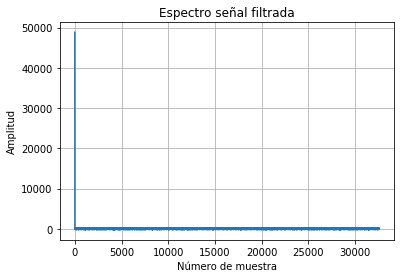

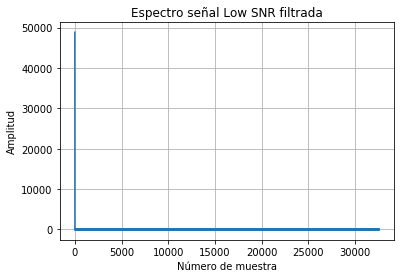

In [7]:
# Calculo del espectro de la se√±al
S_signal = np.fft.fft(signal)

# Calculo del espectro de la se√±al Low SNR
S_signalLowSNR = np.fft.fft(signalLowSNR)

# Graficado de los espectros de las se√±ales filtradas
figures = ['Espectro se√±al filtrada', 'Espectro se√±al Low SNR filtrada']
xlabel = 'N√∫mero de muestra'
ylabel = 'Amplitud'

# Se√±al filtrada
plt.figure(figures[0])
plt.title(figures[0])
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.grid(which='both', axis='both')
plt.plot(S_signal)

# Se√±al Low SNR filtrada
plt.figure(figures[1])
plt.title(figures[1])
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.grid(which='both', axis='both')
plt.plot(S_signalLowSNR)


In [ ]:
Se observa que ambas est√°n montadas sobre una continua, y se decide calcular la media como un estimador de dicha continua.

In [8]:
# Media de se√±al
mean_signal = np.mean(signal_filtered)
print(mean_signal)

# Media de se√±al Low SNR
mean_signalLowSNR = np.mean(signalLowSNR_filtered)
print(mean_signalLowSNR)

1.5032038756584587
1.499998349572931


In [ ]:
Se reconstruye la trama digitalizada y se analizan los resultados:

In [50]:
# Elimino la continua de las se√±ales filtradas
signal_filtered = signal_filtered - mean_signal
signalLowSNR_filtered = signalLowSNR_filtered - mean_signalLowSNR

# Genero la trama digitalizada de se√±al
digitalBurst_signal = signal_filtered
digitalBurst_signalLowSNR = signalLowSNR_filtered

digitalBurst_signal[digitalBurst_signal > 0] = 1
digitalBurst_signal[digitalBurst_signal < 0] = 0

# Genero la trama digitalizada de se√±al Low SNR
digitalBurst_signalLowSNR[digitalBurst_signalLowSNR > 0] = 1
digitalBurst_signalLowSNR[digitalBurst_signalLowSNR < 0] = 0

print(digitalBurst_signal[:128].reshape(16,8))
print(digitalBurst_signalLowSNR[:128].reshape(16,8))

[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 1.]
 [1. 0. 0. 0. 1. 1. 0. 1.]
 [1. 1. 1. 1. 1. 0. 0. 1.]
 [1. 1. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 0. 0.]
 [1. 0. 1. 1. 0. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 1. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 1.]]
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]


##### Se observa que en la decodificaci√≥n de la se√±al signal.npy el header detectado difiere del original en 14 bits; mientras que para el caso de la se√±al signalLowSNR.npy es error es de 1 bit.

##### Como en ambos casos se detectaron errores de demodulaci√≥n, puede inferirse que el umbral elegido no es √≥ptimo. 

<div class="alert alert-block alert-info">
    
#### PARTE 2

##### Repetir el procedimiento para la parte 1, pero utilizar el filtro y el umbral √≥ptimo.

</div>

El problema de detectar pulsos transmitidos sobre un canal AWGN (Additive White Gaussian Noise), en el cual el ruido afecta de forma independiente a cada muestra de se√±al, se reduce al dise√±o de un filtro que permita minimizar los efectos del ruido a su salida, con el objetivo de maximizar la detecci√≥n del pulso de se√±al.

Tal filtro se denomina "Filtro Adaptado" (Matched Filter) y es comunmente utilizado en los sistemas de comunicaci√≥n, dado que permite maximizar la relaci√≥n se√±al a ruido ($SNR$), minimizando la probabilidad de errores en la detecci√≥n de la se√±al.

El filtro adaptado se obtiene mediante la correlaci√≥n de un se√±al retardada conocida (plantilla), con una se√±al desconocida; lo que equivale a convolusionar la se√±al desconocida con una versi√≥n conjugada invertida en el tiempo de la plantilla.

Se grafican a continuaci√≥n las primeras 128 muestras de las se√±ales digitalizadas filtradas signal.npy y signalLowSNR.npy.

<StemContainer object of 3 artists>

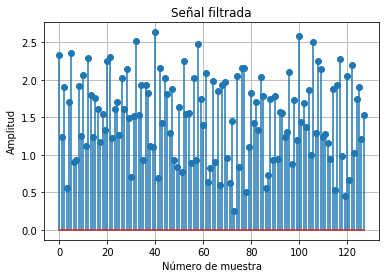

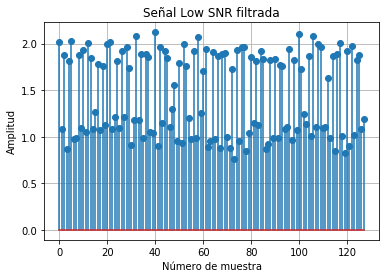

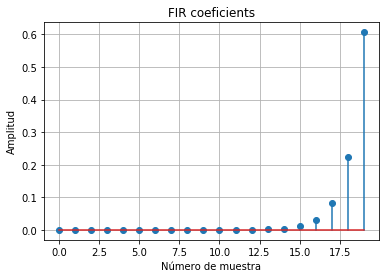

In [29]:
#%% Create FIR coeficients by time reversing the template
template = pulse[::-1]

#%% Filter signal with time reverse template
signal_MFfiltered = sig.convolve(template, signal)

#%% Filter signal Low SNR with time reverse template
signalLowSNR_MFfiltered = sig.convolve(template, signalLowSNR)

#%% Downsampling
signal_filtered = signal_MFfiltered[20::20]
signalLowSNR_filtered = signalLowSNR_MFfiltered[20::20]

#%% Grafico de resultados
figures = ['Se√±al filtrada', 'Se√±al Low SNR filtrada', 'FIR coeficients']
xlabel = 'N√∫mero de muestra'
ylabel = 'Amplitud'

for figure in figures:
    plt.close(figure)

# Se√±al filtrada
plt.figure(figures[0])
plt.title(figures[0])
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.grid(which='both', axis='both')
plt.stem(signal_filtered[:128])

# Se√±al Low SNR filtrada
plt.figure(figures[1])
plt.title(figures[1])
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.grid(which='both', axis='both')
plt.stem(signalLowSNR_filtered[:128])

# Plantilla
plt.figure(figures[2])
plt.title(figures[2])
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.grid(which='both', axis='both')
plt.stem(template)

En relaci√≥n con la pregunta, 

> + ¬øEs √≥ptimo el filtro elegido para detectar la informaci√≥n en forma confiable?

nuevamente se propone analizar cuanta energ√≠a de ruido es eliminada por el filtro implementado, dado que el filtro √≥ptimo ser√° aqu√©l que permita maximizar la relaci√≥n se√±al-a-ruido de la se√±al ($SNR$).

La energ√≠a de la se√±al viene dada por la ecuaci√≥n:

> + $‚àëùëì_s/2ùëì=0|ùëã(ùëì)|2$

In [30]:
# Calculo la energ√≠a de la se√±al filtrada con FIR_MATCHED
S_signalFIR_MATCHED = np.fft.fft(signal_MFfiltered)
energy_SignalFIRMATCHED = sum(np.power(np.abs(S_signalFIR_MATCHED[:N_signal//2]), 2))             

# Calculo la energ√≠a de la se√±al Low SNR filtrada con FIR_FAA
S_signalLowSNRFIR_MATCHED = np.fft.fft(signalLowSNR_MFfiltered)
energy_SignalLowSNRFIRMATCHED = sum(np.power(np.abs(S_signalLowSNRFIR_MATCHED[:N_signalLowSNR//2]), 2))             

# Calculo energ√≠a de la se√±al decimada
S_signalDec = np.fft.fft(signal_filtered)
energy_SignalDec = sum(np.power(np.abs(S_signalDec[:N_signal//2]), 2))             

# Calculo energ√≠ad de la se√±al Low SNR decimada
S_signalLowSNRDec = np.fft.fft(signalLowSNR_filtered)
energy_SignalLowSNRDec = sum(np.power(np.abs(S_signalLowSNRDec[:N_signalLowSNR//2]), 2))             

# Impresi√≥n de los resultados
print(energy_SignalOriginal)
print(energy_SignalFIRMATCHED)
print(energy_SignalDec)
print(energy_SignalLowSNROriginal)
print(energy_SignalLowSNRFIRMATCHED)
print(energy_SignalLowSNRDec)


2585943972.0894594
2282427347.643971
6332656.38960299
2416862474.425469
2211162887.0828385
6001493.481337001


Analizando los resultados previos se observa que para la se√±al:

> + #### Signal.npy

-> El filtro FIR_MATCHED: reduce en un 11,8% la energ√≠a de ruido de la se√±al original
-> El filtro FIR_MATCHED + downsampling: reducen en un 99.75% la energ√≠a de ruido de la se√±al original

> + #### SignaLowSNR.npy

-> El filtro FIR_MATCHED: reduce en un 8,5% la energ√≠a de ruido de la se√±al original
-> El filtro FIR_MATCHED + downsampling: reducen en un 99.75% la energ√≠a de ruido de la se√±al original


##### A diferencia del filtro utilizado en la Parte 1, el filtro adaptado es √≥ptimo, lo cual puede derivarse utilizando el argumento geom√©trico:

##### La intuici√≥n detr√°s del filtro adaptado se basa en la correlaci√≥n de la se√±al recibida (un vector) con un filtro (otro vector) que es paralelo a la se√±al (maximizando el producto interno, lo que mejora la se√±al), y ortogonal al ruido (lo que aten√∫a el ruido presente).

Con el objetivo de determinar el umbral para tomar decisiones, se calculan las probabilidades de medir una amplitud $x$ a la salida del filtro adaptado, para los casos en que se sabe se envi√≥ un 1 √≥ un 0; es decir, $P(x/1)$ y $P(x/0)$, sobre los primeros 128 bits de la se√±al filtrada y submuestreada (correpondiente al header conocido de 16 bytes), para ambas se√±ales.

(array([ 1.,  1.,  1.,  8.,  7., 16., 11., 11.,  3.,  5.]),
 array([1.55276496, 1.60959537, 1.66642578, 1.72325618, 1.78008659,
        1.83691699, 1.8937474 , 1.95057781, 2.00740821, 2.06423862,
        2.12106903]),
 <a list of 10 Patch objects>)

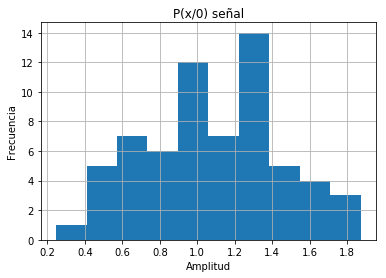

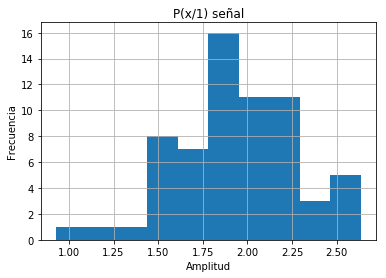

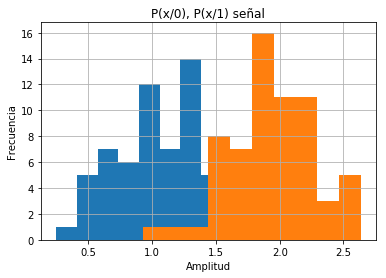

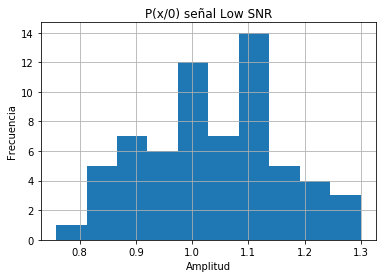

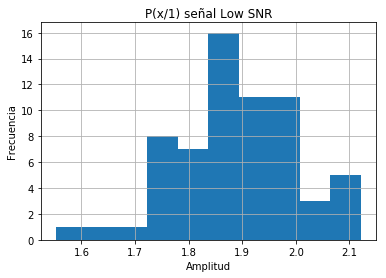

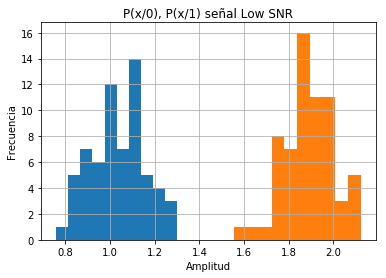

In [31]:
# Arreglos con amplitudes correpondientes a los bits 1 y 0 para la se√±al signal.npy
signal_zeros = []
signal_ones = []

# Arreglos con amplitudes correpondientes a los bits 1 y 0 para la se√±al signalLowSNR.npy
signalLowSNR_zeros = []
signalLowSNR_ones = []

for i in range(0, 128):
    byte_no = np.floor(i/8)*8
    if( ((i % 2 == 0) & (i % (byte_no + 6) != 0)) | (i % (byte_no + 5) == 0) ):
        signal_ones.append(signal_filtered[i])
        signalLowSNR_ones.append(signalLowSNR_filtered[i])
    else:
        signal_zeros.append(signal_filtered[i])
        signalLowSNR_zeros.append(signalLowSNR_filtered[i])

# Grafico de resultados
figures = ['P(x/0) se√±al', 'P(x/1) se√±al', 'P(x/0), P(x/1) se√±al', 'P(x/0) se√±al Low SNR', 'P(x/1) se√±al Low SNR', 'P(x/0), P(x/1) se√±al Low SNR']
xlabel = 'Amplitud'
ylabel = 'Frecuencia'

for figure in figures:
    plt.close(figure)

# P(x/0) se√±al
plt.figure(figures[0])
plt.title(figures[0])
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.grid(which='both', axis='both')
plt.hist(signal_zeros)

# P(x/1) se√±al
plt.figure(figures[1])
plt.title(figures[1])
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.grid(which='both', axis='both')
plt.hist(signal_ones)

# P(x/0), P(x/1) se√±al
plt.figure(figures[2])
plt.title(figures[2])
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.grid(which='both', axis='both')
plt.hist(signal_zeros)
plt.hist(signal_ones)

# P(x/0) se√±al Low SNR
plt.figure(figures[3])
plt.title(figures[3])
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.grid(which='both', axis='both')
plt.hist(signalLowSNR_zeros)

# P(x/1) se√±al Low SNR
plt.figure(figures[4])
plt.title(figures[4])
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.grid(which='both', axis='both')
plt.hist(signalLowSNR_ones)

# P(x/0), P(x/1) se√±al
plt.figure(figures[5])
plt.title(figures[5])
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.grid(which='both', axis='both')
plt.hist(signalLowSNR_zeros)
plt.hist(signalLowSNR_ones)


En base a los histogramas, se observa lo siguiente:

> + #### SignaLowSNR.npy

Las probabilidades de medir determinada amplitud al haber enviado 1 √≥ 0 no se solapan, con lo cual es posible determinar un umbral √≥ptimo que permita demodular los bits con 100% de efectividad.

Dicho umbral podr√≠a considerarse como la media entre los desv√≠os m√°ximos de las probabilidades graficadas, es decir:

> + $Umbral_{amplitud} = (1.3 + 1.55)/2 = 1.425$ 

> + #### Signal.npy

Las probabilidades de medir determinada amplitud al haber enviado 1 √≥ 0 se solapan en el rango de amplitudes $[0,75, 1,9]$, con lo cual no es posible determinar un umbral √≥ptimo que permita demodular los bits con 100% de efectividad.

No obstante, lo m√°s conveniento a fin de reducir el error de detecci√≥n es seleccionar la aplitud para la cual ambas curvas de probabilidad se pisan, es decir:

> + $Umbral_{amplitud} = 1.425$ 

In [ ]:
Se reconstruye la trama digitalizada y se analizan los resultados:

In [32]:
# Elimino la continua de las se√±ales filtradas
signal_filtered = signal_filtered - 1.425
signalLowSNR_filtered = signalLowSNR_filtered - 1.425

# Genero la trama digitalizada de se√±al
digitalBurst_signal = signal_filtered
digitalBurst_signalLowSNR = signalLowSNR_filtered

digitalBurst_signal[digitalBurst_signal > 0] = 1
digitalBurst_signal[digitalBurst_signal < 0] = 0

# Genero la trama digitalizada de se√±al Low SNR
digitalBurst_signalLowSNR[digitalBurst_signalLowSNR > 0] = 1
digitalBurst_signalLowSNR[digitalBurst_signalLowSNR < 0] = 0

print(digitalBurst_signal[:128].reshape(16,8))
print(digitalBurst_signalLowSNR[:128].reshape(16,8))

[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 1.]
 [1. 0. 1. 0. 1. 1. 0. 1.]
 [1. 0. 1. 1. 1. 1. 0. 1.]
 [1. 1. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 1.]
 [0. 0. 1. 0. 1. 1. 1. 0.]
 [1. 0. 1. 1. 0. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 1. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 1.]]
[[1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0.]]


##### Se observa que en la decodificaci√≥n de la se√±al signal.npy el header detectado nuevamente difiere del original en 14 bits; mientras que para el caso de la se√±al signalLowSNR.npy, ahora la efectividad es del 100%.

#### En ambos casos, el umbral de decisi√≥n elegido es √≥ptimo (el mejor posible).